In [1]:
# Importing the necessary packages
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, hinge_loss, log_loss, classification_report, f1_score 
from sklearn.metrics import roc_curve, auc, accuracy_score,  roc_auc_score 
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
# Reading the data from the csv file
Data = pd.read_csv('Final.csv')
Data.columns = Data.columns.str.strip()
print(Data.columns.values)
Data.Status.value_counts()
Data.head()

['avg_R' 'avg_Q' 'avg_S' 'avg_riseTime' 'avg_fallTime' 'avg_riseLevel'
 'avg_fallLevel' 'Ratio1' 'Ratio2' 'Ratio3' 'Bpm' 'Status']


,avg_R,avg_Q,avg_S,avg_riseTime,avg_fallTime,avg_riseLevel,avg_fallLevel,Ratio1,Ratio2,Ratio3,Bpm,Status
0,0.23106,0.043126,0.037694,26.923,21.154,274.19,268.75,0.90294,1.0951,0.99933,74,N
1,0.17053,0.013864,0.057514,18.981,15.278,184.39,113.01,0.89468,1.1046,0.99976,50,A
2,0.41064,0.066886,0.063237,29.293,22.475,477.53,473.88,0.89039,1.1089,0.99976,71,N
3,0.10159,0.044483,0.018901,29.060,27.778,146.07,120.49,0.90176,1.0979,0.99989,105,A
4,0.28479,0.017720,0.055267,36.310,73.611,302.51,340.06,0.91841,1.0822,1.00020,83,N


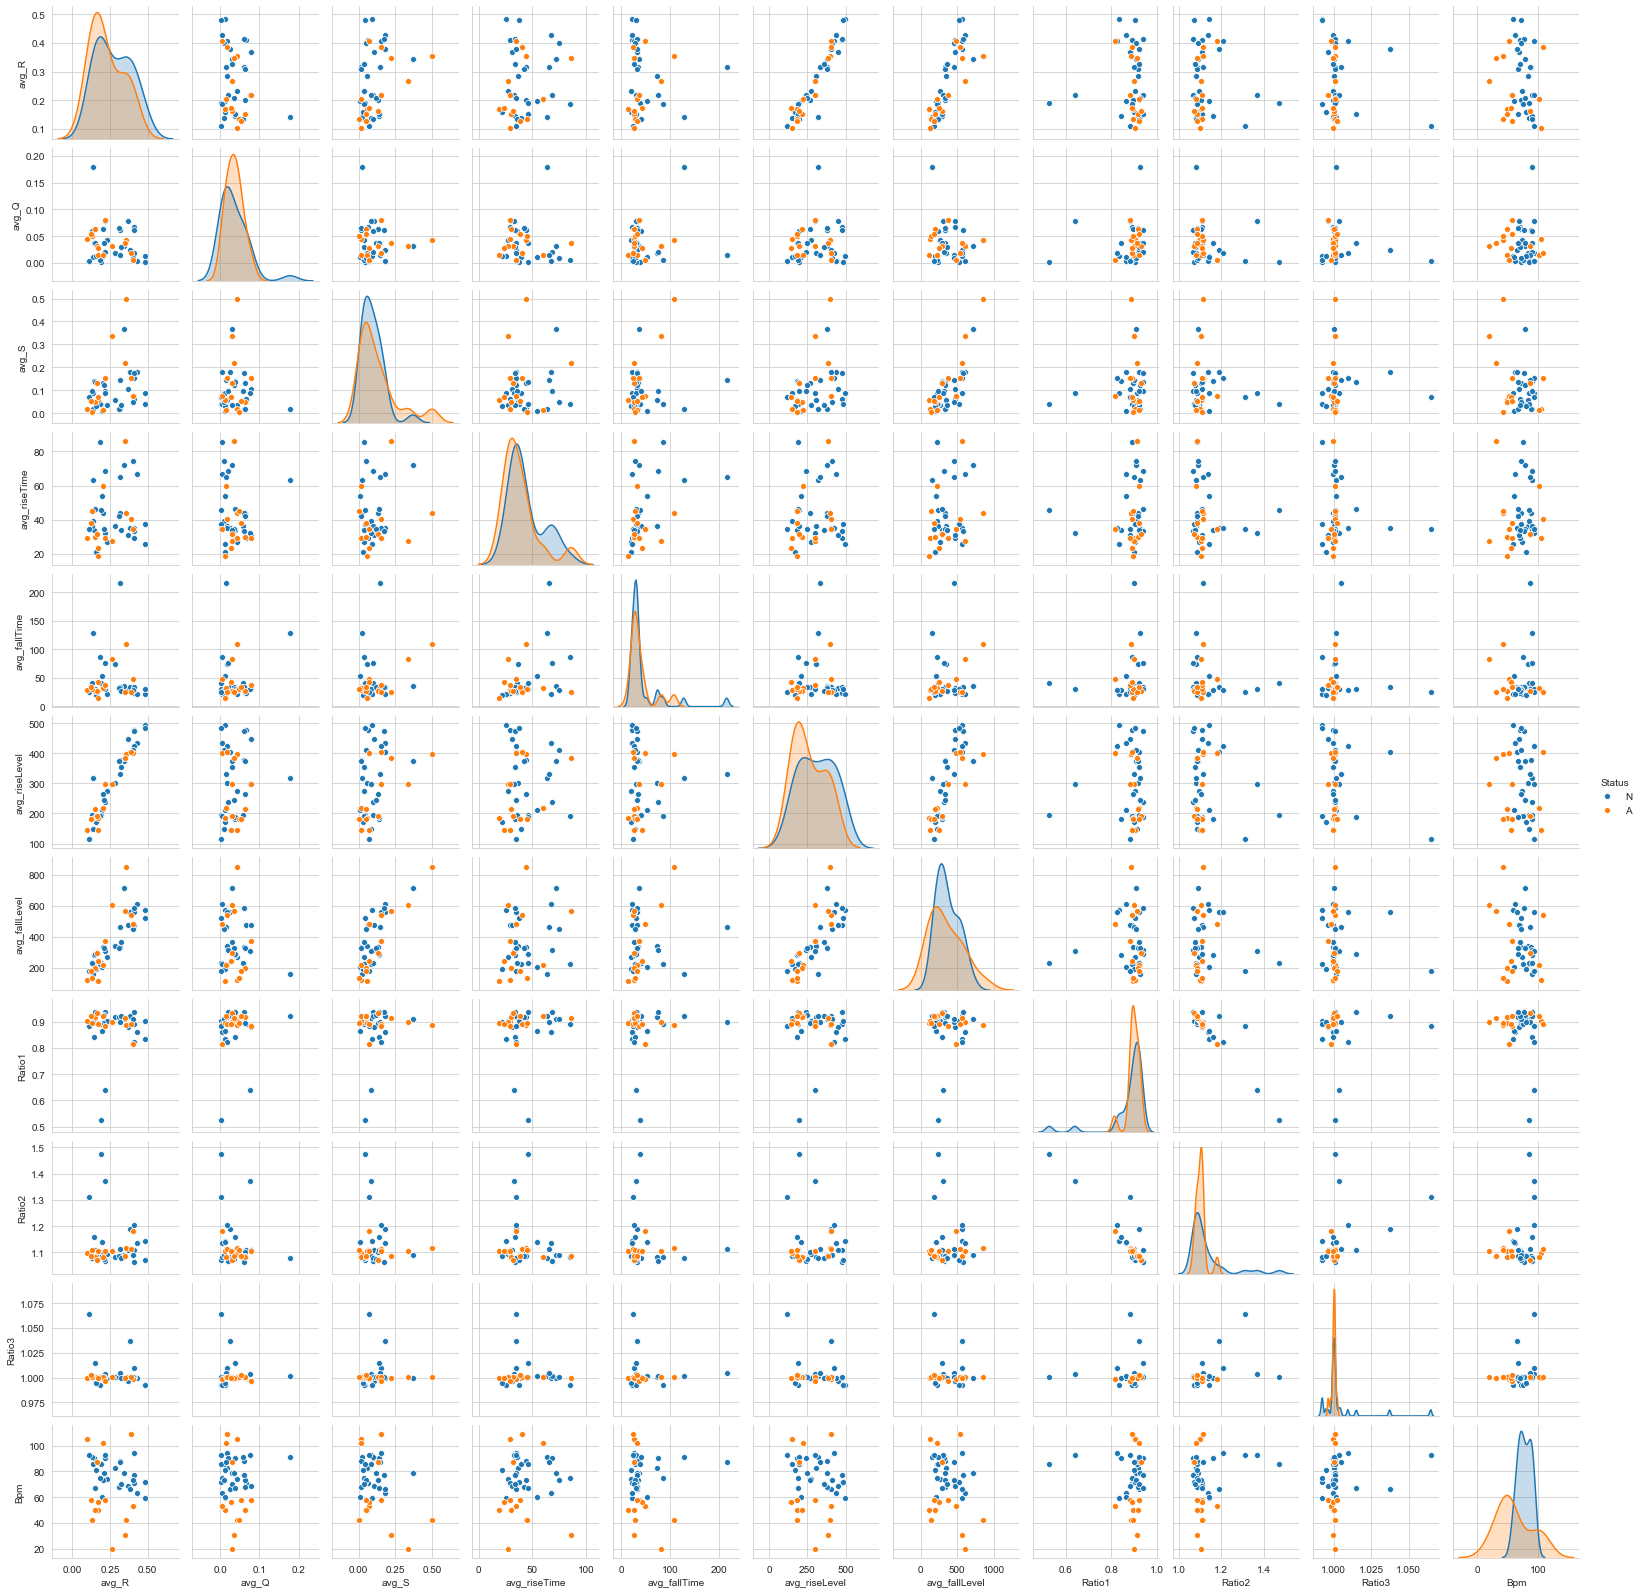

In [3]:
# Pair-wise plot
plt.close();
sns.set_style("whitegrid");
sns.pairplot(Data, hue="Status", size=2);
plt.show()

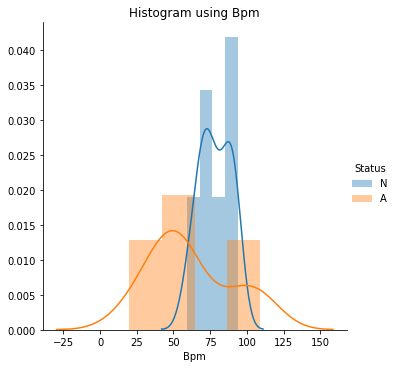

In [3]:
# Histogram plot of Bpm
sns.FacetGrid(Data, hue="Status", size=5) \
   .map(sns.distplot, "Bpm") \
   .add_legend();
plt.title("Histogram using Bpm")
plt.show();

N    30
A    14
Name: Status, dtype: int64


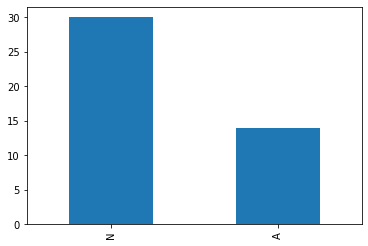

In [4]:
print(Data['Status'].value_counts())
Data['Status'].value_counts().plot(kind = 'bar')

In [3]:
# Replacing Normal as 0 and Abnormal as 1
Data["Status"].replace({"N": 0, "A": 1}, inplace=True)

In [4]:
print(Data.head())
X = Data.drop('Status', axis = 1).values
Y = Data['Status'].values

     avg_R     avg_Q     avg_S  avg_riseTime  avg_fallTime  avg_riseLevel  \
0  0.23106  0.043126  0.037694        26.923        21.154         274.19   
1  0.17053  0.013864  0.057514        18.981        15.278         184.39   
2  0.41064  0.066886  0.063237        29.293        22.475         477.53   
3  0.10159  0.044483  0.018901        29.060        27.778         146.07   
4  0.28479  0.017720  0.055267        36.310        73.611         302.51   

   avg_fallLevel   Ratio1  Ratio2   Ratio3  Bpm  Status  
0         268.75  0.90294  1.0951  0.99933   74       0  
1         113.01  0.89468  1.1046  0.99976   50       1  
2         473.88  0.89039  1.1089  0.99976   71       0  
3         120.49  0.90176  1.0979  0.99989  105       1  
4         340.06  0.91841  1.0822  1.00020   83       0  


In [5]:
X.shape, Y.shape

((44, 11), (44,))

In [6]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.21, stratify = Y, random_state = 1)

In [7]:
X_train.shape, X_test.shape

((34, 11), (10, 11))

In [8]:
# Standardizing the data
scaler = StandardScaler()
scaler.fit(X_train)

x_train_std = scaler.transform(X_train)
x_test_std = scaler.transform(X_test)

In [9]:
# This function is used to plot Cofusion Matrix, Precision Matrix and Recall Matrix.
def plot_matrices(Y, Y_Pred):
    C = confusion_matrix(Y, Y_Pred) # Confusion Matrix
    
    A =(((C.T)/(C.sum(axis=1))).T) # Calculating Recall Matrix
    
    B =(C/C.sum(axis=0)) # Calculating Precision Matrix
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    print("Sum of rows in recall matrix",A.sum(axis=1))
    
    plt.show()


In [11]:
# This function prints the metrics of the model.
def Metrics(model, X, Y):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)

    print("The Prescision Score: ", precision_score(Y, y_pred))
    print("The Recall Score: ", recall_score(Y, y_pred))
    print("The ROC Score: ", roc_auc_score(Y, y_pred_prob))
    print("The F1 Score: ", f1_score(Y, y_pred))
    print("The Log loss: ", log_loss(Y, y_pred_prob))
    print('*'*100)
    print(classification_report(Y, y_pred))
    print('*'*100)
    plot_matrices(Y, y_pred)

In [271]:
balance = [{0: 1.9, 1: 3}, {0:3, 1:1.9}]

#### KNN

In [48]:
# Hyperparameter tuning of KNN using gridsearchcv
neigh = KNeighborsClassifier()
parameters = {'n_neighbors': [3, 5, 7, 9, 12, 15, 17, 20, 25, 27],
             'weights' : ['uniform', 'distance']}
clf = GridSearchCV(neigh, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(x_train_std, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 12, 15, 17, 20, 25, 27],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='roc_auc')

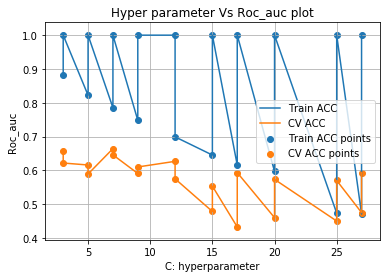

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.000790,0.000668,0.006615,0.009123,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.80,0.3,0.9,...,0.658333,0.203988,2,0.842593,0.950617,0.824074,0.891447,0.897661,0.881278,0.044606
1,0.000200,0.000399,0.002994,0.003346,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.70,0.3,0.9,...,0.621667,0.194193,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.000000,0.000000,0.011952,0.013441,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.95,0.1,0.8,...,0.615833,0.288824,6,0.746914,0.867284,0.765432,0.898026,0.833333,0.822198,0.057960
3,0.000000,0.000000,0.008559,0.005060,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.90,0.1,0.8,...,0.589167,0.276079,11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.000893,0.001344,0.007813,0.006583,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.95,0.1,1.0,...,0.664167,0.324054,1,0.645062,0.870370,0.802469,0.769737,0.839181,0.785364,0.077902


In [49]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_acc= results['mean_train_score']
train_acc_std= results['std_train_score']
cv_acc = results['mean_test_score'] 
cv_acc_std= results['std_test_score']
K = results['param_n_neighbors']

plt.plot(K, train_acc, label='Train ACC')
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_acc, label='CV ACC')
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_acc, label='Train ACC points')
plt.scatter(K, cv_acc, label='CV ACC points')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("Roc_auc")
plt.title("Hyper parameter Vs Roc_auc plot")
plt.grid(True)
plt.show()

results.head()

Above plot shows the auc score w.r.t hyperparameter C

In [50]:
clf.best_params_, clf.best_score_

({'n_neighbors': 7, 'weights': 'uniform'}, 0.6641666666666666)

In [51]:
# Using the best model
neigh = KNeighborsClassifier(n_neighbors = 7, weights = 'uniform')

In [52]:
# Calibrating the probability scores using Calibrated Classifier
neigh.fit(x_train_std, y_train)
sig_clf = CalibratedClassifierCV(neigh, method="isotonic")
sig_clf.fit(x_train_std, y_train)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(n_neighbors=7),
                       method='isotonic')

In [53]:
y_train_pred = sig_clf.predict_proba(x_train_std)[:, 1]
y_test_pred = sig_clf.predict_proba(x_test_std)[:, 1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

The Prescision Score:  0.8
The Recall Score:  0.7272727272727273
The ROC Score:  0.8241106719367589
The F1 Score:  0.761904761904762
The Log loss:  0.4522424358026891
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        23
           1       0.80      0.73      0.76        11

    accuracy                           0.85        34
   macro avg       0.84      0.82      0.83        34
weighted avg       0.85      0.85      0.85        34

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


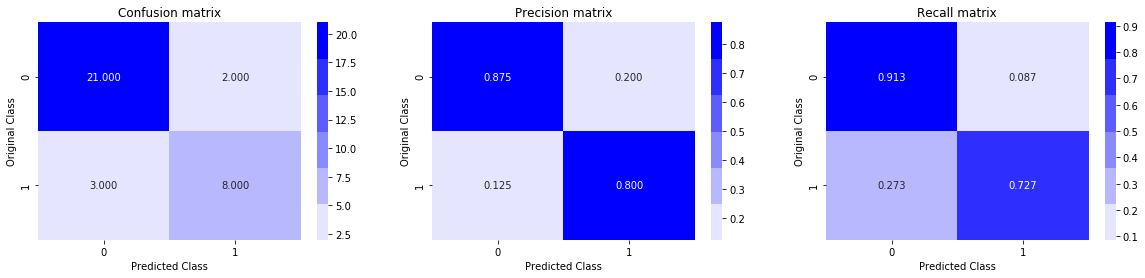

The Prescision Score:  0.4
The Recall Score:  0.6666666666666666
The ROC Score:  0.6428571428571428
The F1 Score:  0.5
The Log loss:  0.719816266607873
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.40      0.67      0.50         3

    accuracy                           0.60        10
   macro avg       0.60      0.62      0.58        10
weighted avg       0.68      0.60      0.62        10

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


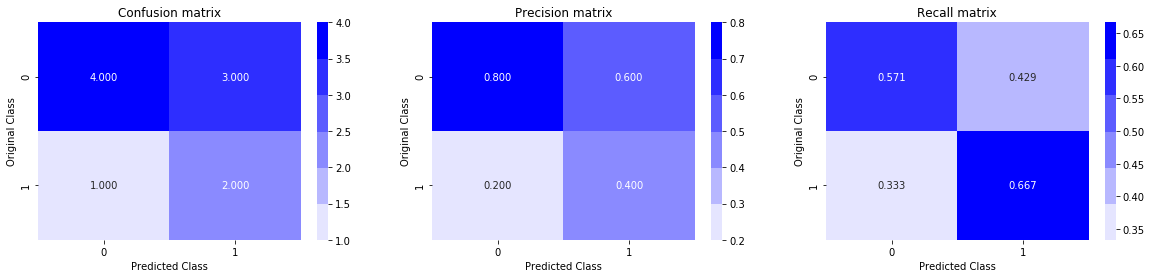

In [144]:
# Getting the metrics based on the optimal threshold value
Metrics(sig_clf, x_train_std, y_train) # Train dataset
print('='*100)
print('='*100)
Metrics(sig_clf, x_test_std, y_test) # Test dataset

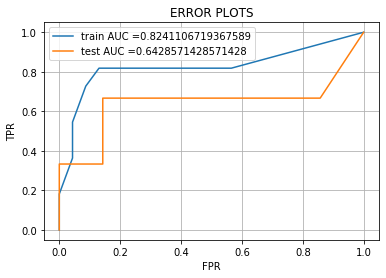

In [145]:
# Plotting ROC curve for Train and Test.
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [40]:
# This function prints the metrics of the model.
def Metrics(model, X, Y, threshold):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)

    print("The Prescision Score: ", precision_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print("The Recall Score: ", recall_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print("The ROC Score: ", roc_auc_score(Y, y_pred_prob))
    print("The F1 Score: ", f1_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print("The Log loss: ", log_loss(Y, y_pred_prob))
    print('*'*100)
    print(classification_report(Y, predict_with_best_t(y_pred_prob, threshold)))
    print('*'*100)
    plot_matrices(Y, predict_with_best_t(y_pred_prob, threshold))

In [237]:
def find_best_threshold(threshould, fpr, tpr):
    # This function finds the optimal threshold value based on G-Mean metric
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of (tpr*(1-fpr))", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould): # This function predicts class labels based on the optimal threshold value.
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### SVC

In [24]:
# Hyperparameter tuning of Kernel SVC using Randomizedsearchcv
svc = SVC(decision_function_shape = 'ovo', probability = True)
parameters = {'C' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
             'gamma': [1, 10, 100, 1000], 
              'degree': [2, 3, 4, 5, 6],
              'kernel' : ['rbf', 'poly', 'sigmoid'],
              'class_weight' : balance
             }
clf = RandomizedSearchCV(svc, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(x_train_std, y_train)

RandomizedSearchCV(cv=5,
                   estimator=SVC(decision_function_shape='ovo',
                                 probability=True),
                   n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000],
                                        'class_weight': [{0: 1.9, 1: 3},
                                                         {0: 3, 1: 1.9}],
                                        'degree': [2, 3, 4, 5, 6],
                                        'gamma': [1, 10, 100, 1000],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   return_train_score=True, scoring='roc_auc')

In [25]:
clf.best_estimator_

SVC(C=0.001, class_weight={0: 1.9, 1: 3}, decision_function_shape='ovo',
    degree=2, gamma=10, kernel='poly', probability=True)

In [26]:
clf.best_params_, clf.best_score_

({'kernel': 'poly',
  'gamma': 10,
  'degree': 2,
  'class_weight': {0: 1.9, 1: 3},
  'C': 0.001},
 0.8066666666666666)

In [233]:
# Using the best model
svc = clf.best_estimator_
svc

SVC(C=0.001, class_weight={0: 1.9, 1: 3}, decision_function_shape='ovo',
    degree=2, gamma=10, kernel='poly', probability=True)

In [234]:
# Calibrating the probability scores using Calibrated Classifier
svc.fit(x_train_std, y_train)
sig_clf = CalibratedClassifierCV(svc, method="isotonic")
sig_clf.fit(x_train_std, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=0.001, class_weight={0: 1.9, 1: 3},
                                          decision_function_shape='ovo',
                                          degree=2, gamma=10, kernel='poly',
                                          probability=True),
                       method='isotonic')

In [235]:
y_train_pred = sig_clf.predict_proba(x_train_std)[:, 1]
y_test_pred = sig_clf.predict_proba(x_test_std)[:, 1]

In [238]:
# Threshold Tuning based on the Test Dataset.
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)
best_t = find_best_threshold(test_thresholds, test_fpr, test_tpr)

the maximum value of (tpr*(1-fpr)) 1.0 for threshold 0.277


The Prescision Score:  1.0
The Recall Score:  1.0
The ROC Score:  1.0
The F1 Score:  1.0
The Log loss:  0.3056401516041227
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        11

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


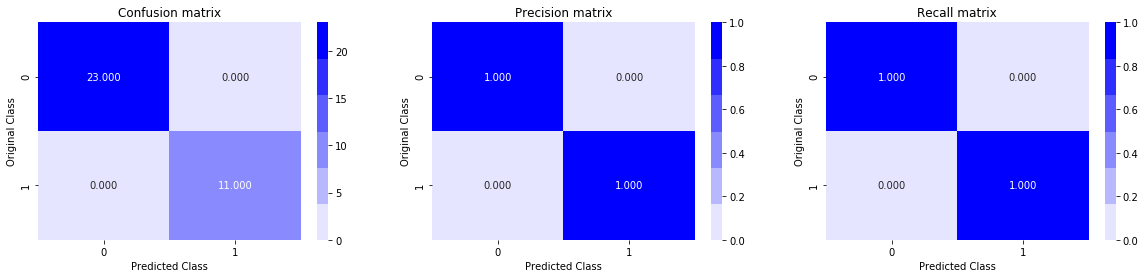

The Prescision Score:  1.0
The Recall Score:  1.0
The ROC Score:  1.0
The F1 Score:  1.0
The Log loss:  0.3669323888723467
****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


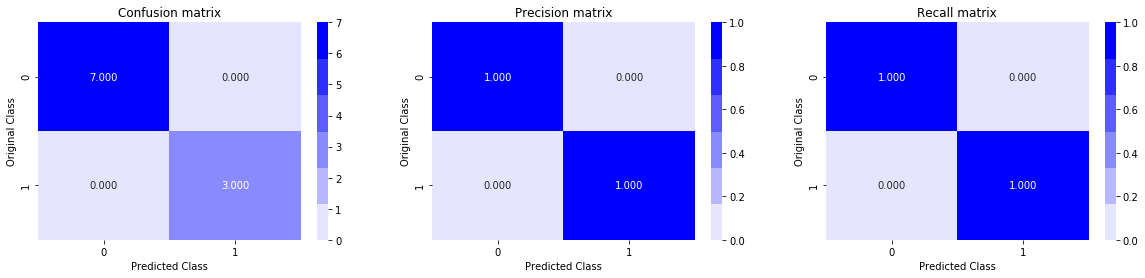

In [31]:
# Getting the metrics based on the optimal threshold value
Metrics(sig_clf, x_train_std, y_train, best_t) # Train dataset
print('='*100)
print('='*100)
Metrics(sig_clf, x_test_std, y_test, best_t) # Test dataset

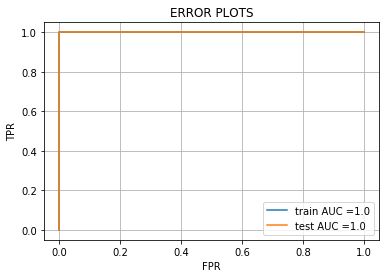

In [34]:
# Plotting ROC curve for Train and Test.
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Logistic Regression

In [224]:
# Hyperparameter tuning for SGD classifier with log-loss using Randomizedsearchcv
param = {'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],
         'penalty' : ['l1', 'l2', 'elasticnet'],
         'l1_ratio' : list(np.sort(np.random.uniform(0, 1, 10))),
         'class_weight' : balance}
LR = SGDClassifier(loss='log', n_jobs = -1)
clf = RandomizedSearchCV(LR, param, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(x_train_std, y_train)

RandomizedSearchCV(cv=5, estimator=SGDClassifier(loss='log', n_jobs=-1),
                   n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10.0, 100.0, 1000.0, 10000.0,
                                                  100000.0],
                                        'class_weight': [{0: 1.9, 1: 3},
                                                         {0: 3, 1: 1.9}],
                                        'l1_ratio': [0.050816749832600094,
                                                     0.14928521136863093,
                                                     0.14998088980151958,
                                                     0.21479264802445008,
                                                     0.24725784331690126,
                                                     0.2557988091296084,
                                                     0.3299113388361159,
             

In [225]:
clf.best_params_, clf.best_score_

({'penalty': 'elasticnet',
  'l1_ratio': 0.050816749832600094,
  'class_weight': {0: 3, 1: 1.9},
  'alpha': 0.1},
 0.6833333333333333)

In [239]:
# Using the best model
LR = clf.best_estimator_
LR

SGDClassifier(alpha=0.1, class_weight={0: 3, 1: 1.9},
              l1_ratio=0.050816749832600094, loss='log', n_jobs=-1,
              penalty='elasticnet')

In [240]:
# Calibrating the probability scores using Calibrated Classifier
LR.fit(x_train_std, y_train)
sig_clf = CalibratedClassifierCV(LR, method="isotonic")
sig_clf.fit(x_train_std, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.1,
                                                    class_weight={0: 3, 1: 1.9},
                                                    l1_ratio=0.050816749832600094,
                                                    loss='log', n_jobs=-1,
                                                    penalty='elasticnet'),
                       method='isotonic')

In [241]:
y_train_pred = sig_clf.predict_proba(x_train_std)[:, 1]
y_test_pred = sig_clf.predict_proba(x_test_std)[:, 1]

In [242]:
# Threshold Tuning based on the Test Dataset.
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)
best_t = find_best_threshold(test_thresholds, test_fpr, test_tpr)

the maximum value of (tpr*(1-fpr)) 0.6666666666666666 for threshold 0.867


The Prescision Score:  1.0
The Recall Score:  0.45454545454545453
The ROC Score:  0.8794466403162053
The F1 Score:  0.625
The Log loss:  0.3586656156260808
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        23
           1       1.00      0.45      0.62        11

    accuracy                           0.82        34
   macro avg       0.90      0.73      0.75        34
weighted avg       0.86      0.82      0.80        34

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


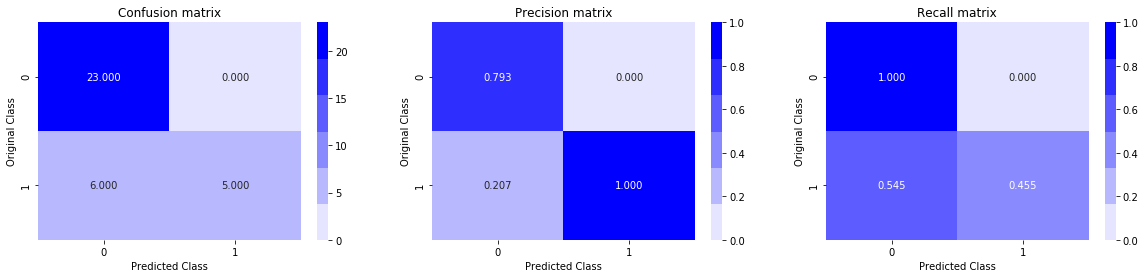

The Prescision Score:  1.0
The Recall Score:  0.6666666666666666
The ROC Score:  0.6666666666666666
The F1 Score:  0.8
The Log loss:  0.5353937599773955
****************************************************************************************************
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.67      0.80         3

    accuracy                           0.90        10
   macro avg       0.94      0.83      0.87        10
weighted avg       0.91      0.90      0.89        10

****************************************************************************************************
Sum of columns in precision matrix [1. 1.]
Sum of rows in recall matrix [1. 1.]


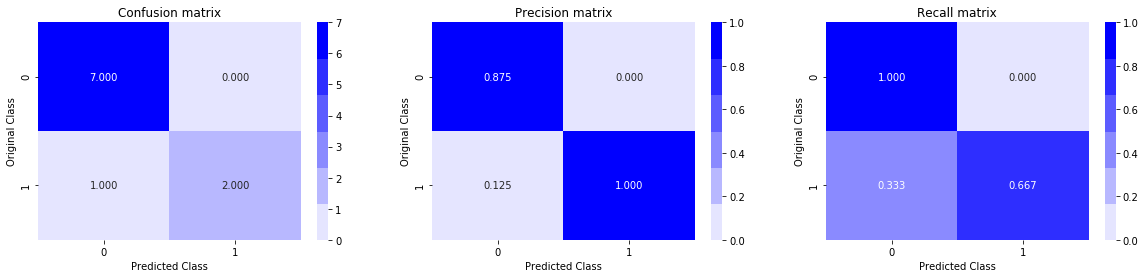

In [243]:
# Getting the metrics based on the optimal threshold value
Metrics(sig_clf, x_train_std, y_train, best_t) # Train dataset
print('='*100)
print('='*100)
Metrics(sig_clf, x_test_std, y_test, best_t) # Test dataset

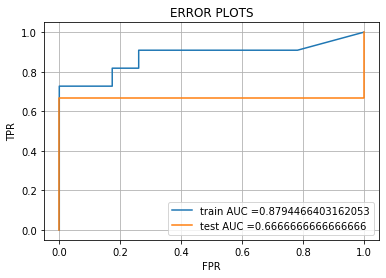

In [244]:
# Plotting ROC curve for Train and Test.
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Summary

|  Data|Model| Precision  | Recall | ROC-Score | F1-Score | Log-loss |
|------------|----|--------|----------------------|----------|----------||
|      Train |KNN|  0.8|   0.7272 |  0.8241 | 0.7619 | 0.45224 |
|     | Kernel SVC|  1.0    |  1.0     |  1.0 |1.0| 0.3056
|      |Logistic Regression|    1.0  |    0.4545  |   0.8794 |0.625| 0.3586 |


|  Data|Model| Precision  | Recall | ROC-Score | F1-Score | Log-loss |
|------------|----|--------|----------------------|----------|----------||
|      Test |KNN|  0.4  |    0.666 |   0.6428 |0.5 | 0.7198 |
|     |Kernel SVC| 1.0  |    1.0  |   1.0 |1.0| 0.3669|
|      |Logistic Regression|   1.0 |    0.6666  |  0.6666 |0.8 | 0.5354

From the above summary it is seen that Kernel SVC performs well on Test Data than the other models with log-loss of 0.3669 without overfitting.